## haMSM for Eg5-ADP WT Unbinding WE Simulation Data
---
Using pairwise distances of ADP (370) to Eg5 CA (18-364) for featurization.

The change here is that I am using the slightly adjusted binning scheme from the sigmoidal transform nb, hopefully this will lead to no negative pSS elements and also will allow for more direct comparisons.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tqdm.auto

In [2]:
pwd

'/ix/lchong/dty7/eg5/h2p-we/multi-mab_nomon_v01/haMSM'

In [3]:
from msm_we import msm_we
import mdtraj as md

In [4]:
import ray
ray.init(num_cpus=8)
#ray.init()

2023-08-31 11:52:42,385	INFO worker.py:1616 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Python version:,3.10.11
Ray version:,2.4.0
Dashboard:,http://127.0.0.1:8266


In [5]:
#ray.shutdown()

Model Name

In [6]:
model_name = 'Eg5_WT_ADP_CA_18-364_upbins'

In [7]:
import logging
from rich.logging import RichHandler
log = logging.getLogger()
log.addHandler(RichHandler())

msm_log = logging.getLogger("msm_we.msm_we")

In [8]:
def processCoordinates(self, coords):
    log.debug("Processing coordinates")

    if self.dimReduceMethod == "none":
        xt = md.Trajectory(xyz=coords, topology=None)
        indCA = self.reference_structure.topology.select("name CA")
        indAlign = self.reference_structure.topology.select("name CA")
        x2 = xt.superpose(self.reference_structure,atom_indices=indAlign)
        coords = x2._xyz.astype('float64')
        nA = np.shape(indCA)[0]
        nC = np.shape(coords)[0]
        new_coords = coords[:,tuple(indCA),:]
        #new_coords = numpy.double(new_coords)
        #new_coords = coords[:, :923, :]
        data = new_coords.reshape(nC, 3 * nA)
        model.nAtoms = nA
        return data

    if self.dimReduceMethod == "pca" or self.dimReduceMethod == "vamp":

        # Dimensionality reduction
        
        xt = md.Trajectory(xyz=coords, topology=None)
        # ADP heavy atoms
        indADP = self.reference_structure.topology.select("not type H and resid 370")
        # CA atoms of loop 5
        #indCA = self.reference_structure.topology.select("name CA and resid 116 to 133")
        # CA atoms of Eg5 (non-flexible termini)
        indCA = self.reference_structure.topology.select("name CA and resid 18 to 364")
        # calc distance matrix
        pair1, pair2 = np.meshgrid(indADP, indCA, indexing="xy")
        
        ### for 2D distance matrices ###
        #pair1, pair2 = np.meshgrid(indCA, indCA, indexing="xy")
        #indUT = np.where(np.triu(pair1, k=1) > 0)
        #pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
        #dist = md.compute_distances(xt, pairs, periodic=True, opt=True)
        
        ### special for 1D distance matrix of ADP-Eg5 ###
        # make pair array
        pairs = np.array((pair1, pair2))
        # reduce dim to 2
        pairs = pairs.squeeze()
        # convert to shape (n_pairs, 2) where row items are the atom index pair vals
        pairs = np.rot90(pairs, k=-1)
        #indUT = np.where(np.triu(pair1, k=1) > 0)
        #pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
        dist = md.compute_distances(xt, pairs, periodic=True, opt=True)

        return dist

# Monkey-patch, i.e. replace the placeholder processCoordinates method in msm_we.modelWE
msm_we.modelWE.processCoordinates = processCoordinates

Testing different `processCoordinates` code. Needs to be adjusted to handle non-2D distance matrix type data.

In [72]:
xt = md.load("eg5_2022_dry.pdb", top="eg5_2022_dry.pdb")
#xt = md.Trajectory(xyz=coords, topology=None)
# ADP heavy atoms
indADP = xt.topology.select("not type H and resid 370")
# CA atoms of Eg5 (non-flexible termini)
indCA = xt.topology.select("name CA and resid 18 to 364")

#pair1, pair2 = np.meshgrid(indADP, indCA, indexing="xy")
#pair1, pair2 = np.meshgrid(indCA, indCA, indexing="xy")

# make pair array
pairs = np.array((pair1, pair2))
# reduce dim to 2
pairs = pairs.squeeze()
# convert to shape (n_pairs, 2) where row items are the atom index pair vals
pairs = np.rot90(pairs, k=-1)
#indUT = np.where(np.triu(pair1, k=1) > 0)
#pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
dist = md.compute_distances(xt, pairs, periodic=True, opt=True)

(1, 347)

### Building block-wise haMSM
---

In [9]:
cat ../tstate.file

unbound 12 1 6.1 6.1


Create the model object and initialize it

In [10]:
model =  msm_we.modelWE()
model.initialize(
    fileSpecifier=['west-packopt.h5'], 
    refPDBfile = 'eg5_2022_dry.pdb',
    modelName = model_name,
    basis_pcoord_bounds  = [[0,10], [100,np.inf], [0,6], [0,6]],
    target_pcoord_bounds = [[12,np.inf], [-np.inf,100], [6,np.inf], [6,np.inf]],
    dim_reduce_method = 'pca',
    tau = 50e-12,
    pcoord_ndim = 4,
)

Load all coords and pcoords up to the last iteration you want to use for analysis with

In [11]:
model.get_iterations()
# use up to n last_iter iterations
model.get_coordSet(last_iter=580, streaming=True)

Output()

Prepare dimensionality reduction transformer by running

In [12]:
model.dimReduce()

Output()

In [7]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_postPCA.pickle', 'rb') as f:
    model = load(f)

In [13]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_postPCA.pickle', 'wb') as f:
    dump(model, f)

Get WE bin mapper for cluster stratification

In [14]:
import westpa
from westpa.core.binning import RectilinearBinMapper

# 1) ADP-Mg RMSD
# 2) ADP-Mg and Eg5 IntEne
# 3) ADP and Eg5 min dist
# 4) ADP-PO4 and Eg5 min dist
new_mapper = RectilinearBinMapper([[0, 5, 7, 9, 11, 13, 15, 
                                    17, 19, 22, 26, 30, np.inf],
                                   [-np.inf, -125, -75, -25, 
                                    25, 75, 125, 175, 225, 275, np.inf],
                                   [0, 3, 6, np.inf],
                                   [0, 6, np.inf],
                                  ])

Cluster and store original clustering

In [15]:
model.cluster_coordinates(n_clusters = 10, 
                          stratified = True,
                          tol = 1e-5, 
                          streaming = True, 
                          use_ray = True, 
                          first_cluster_iter = 400,
                          user_bin_mapper = new_mapper, 
                          store_validation_model = True)

[08/30/23 17:43:58] INFO     Be aware: Number of cluster centers is an important parameter, and  ]8;id=596712;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=966434;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#160\160]8;;\
                             can drastically affect model quality. We recommend examining                          
                             block-validation results with a range of numbers of clusters, to                      
                             check for overfitting.                                                                

                    INFO     Loading user-specified bin mapper for stratified clustering.        ]8;id=204290;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=279275;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#585\585]8;;\

                    INFO     Doing stratified clustering with 7200 total clusters       ]8;id=356467;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/stratified_clustering.py\stratified_clustering.py]8;;\:]8;id=251545;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/stratified_clustering.py#66\66]8;;\

Output()

/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bounds = np.array(bin_mapper.boundaries)
/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1380: RuntimeWarning: invalid value encountered in add
  _centers.append(dim[:-1] + (dim[1:] - dim[:-1]) / 2)
/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1373: RuntimeWarning: invalid value encountered in subtract
  return np.sqrt(np.mean(np.power(point - _centers, 2), axis=1))


In [14]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap.pickle', 'rb') as f:
#with open('test_570-580_4Dmap.pickle', 'rb') as f:
    model = load(f)

In [16]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap.pickle', 'wb') as f:
#with open('test_570-580_4Dmap.pickle', 'wb') as f:
    dump(model, f)

In [17]:
model.n_clusters

7200

Create the flux matrix with

In [18]:
model.get_fluxMatrix(n_lag=0, first_iter=400, last_iter=580, use_ray=True)

Output()

In [19]:
model.fluxMatrix

In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postfluxget.pickle', 'rb') as f:
    model = load(f)

In [20]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap_postfluxget.pickle', 'wb') as f:
    dump(model, f)

Clean disconnected states and sort the flux matrix with

In [21]:
# optionally could adjust this cluster class attribute for pcoord sorting selection (default=0)
#model.pcoord_to_use = 0

In [22]:
model.organize_fluxMatrix(use_ray=True)

[08/30/23 18:50:20] INFO     Started with 7200 clusters, and removed 6543                       ]8;id=280127;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=956143;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1050\1050]8;;\

                    WARNING  All clusters were cleaned from bins {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ]8;id=822292;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=24510;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1067\1067]8;;\
                             10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,                       
                             26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,                       
                             42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,                       
                             58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,                       
                             74, 75, 76, 77, 79, 81, 82, 83, 85, 87, 88, 89, 91, 93, 94, 95,                       
                             96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,                     
                             110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,                      
                             123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,                      
                             136, 137, 139, 141, 142, 143, 145, 148, 149, 151, 153, 154, 155,                      
                             156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,                      
                             169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,                      
                             182, 183, 184, 185, 187, 188, 189, 190, 191, 193, 195, 196, 197,                      
                             199, 202, 203, 208, 209, 211, 213, 214, 215, 217, 218, 219, 220,                      
                             221, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 235, 236,                      
                             237, 238, 239, 241, 243, 244, 245, 247, 249, 250, 251, 253, 255,                      
                             256, 257, 259, 262, 263, 265, 268, 269, 271, 272, 273, 274, 275,                      
                             277, 278, 279, 280, 281, 283, 284, 285, 286, 287, 289, 290, 291,                      
                             292, 293, 295, 296, 297, 298, 299, 301, 303, 304, 305, 307, 309,                      
                             310, 311, 313, 316, 317, 319, 322, 323, 325, 328, 329, 331, 332,                      
                             333, 334, 335, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,                      
                             347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,                      
                             361, 363, 364, 365, 367, 369, 370, 371, 373, 376, 377, 379, 382,                      
                             383, 385, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,                      
                             399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,                      
                             412, 413, 414, 415, 416, 417, 418, 419, 421, 423, 424, 425, 427,                      
                             429, 430, 431, 433, 436, 437, 439, 442, 443, 444, 445, 448, 449,                      
                             450, 451, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,                      
                             464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,                      
                             477, 478, 479, 481, 483, 484, 485, 487, 489, 490, 491, 493, 496,                      
                             497, 499, 502, 503, 505, 508, 509, 510, 511, 512, 513, 514, 515,                      
                             516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528,                      
                             529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 541, 543,             

Output()

Output()

/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1632: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.targetRMSD_all = np.array(cluster_pcoord_all)[pcoord_sort_indices]


[08/30/23 19:34:39] INFO     Note: Sorting bins, assuming that pcoord 0 is meaningful for       ]8;id=40147;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=880357;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1643\1643]8;;\
                             sorting                                                                               

In [23]:
model.fluxMatrix

array([[7.46904694e-069, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 6.81764690e-068, 0.00000000e+000],
       [0.00000000e+000, 9.93751731e-086, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 3.30656455e-059, ...,
        0.00000000e+000, 3.30656465e-059, 0.00000000e+000],
       ...,
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        5.79140007e-111, 0.00000000e+000, 6.94968008e-111],
       [1.79048438e-069, 0.00000000e+000, 2.68985864e-052, ...,
        0.00000000e+000, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 0.00000000e+000, 7.84451254e-057]])

In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postfluxorg.pickle', 'rb') as f:
    model = load(f)

In [24]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap_postfluxorg.pickle', 'wb') as f:
    dump(model, f)

### Begin Model Analysis
---

Normalize the flux matrix to produce a transition matrix with

In [25]:
model.get_Tmatrix()

In [26]:
model.Tmatrix

array([[9.87374711e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.01262529e-01, 0.00000000e+00],
       [0.00000000e+00, 5.00000000e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.85294110e-01, ...,
        0.00000000e+00, 4.85294125e-01, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.50000000e-01, 0.00000000e+00, 3.00000000e-01],
       [1.79048438e-69, 0.00000000e+00, 2.68985864e-52, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

Obtain steady-state distribution with

In [27]:
model.get_steady_state()

[08/30/23 19:34:48] INFO     Negative elements in pSS after normalization, attempting to correct   ]8;id=239328;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=10781;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#238\238]8;;\
                             with matrix power method.                                                             

                    WARNING  Power method did NOT obtain semidefinite pSS. Some negative values    ]8;id=83496;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=318996;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#256\256]8;;\
                             remain. This is weird, and you should try to figure out why this is                   
                             happening.                                                                            

                    WARNING  Some negative  elements in pSS... Ignoring, and setting model.pSS     ]8;id=911660;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=315611;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#276\276]8;;\
                             anyways.                                                                              

[08/30/23 19:34:49] INFO                                                                           ]8;id=782136;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=107687;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#179\179]8;;\
                             Flux converged to 1.2739e-10 after 5 iterations of inverse iteration.                 

(array([], dtype=int64),)


In [28]:
model.update_cluster_structures()

In [29]:
model.get_steady_state_target_flux()

print(f'Steady-state target rate is {model.JtargetSS:.2e}')

Steady-state target rate is 1.27e-10


In [9]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postsstflux.pickle', 'rb') as f:
    model = load(f)

In [30]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap_postsstflux.pickle', 'wb') as f:
    dump(model, f)

### Begin Model Validation
---

In [10]:
# shape: clusters, pcoords, min/max
model.targetRMSD_minmax.shape

(659, 4, 2)

In [11]:
# For checking just in case your bins are not good.
array = model.targetRMSD_minmax[:,0,:]
print(array[23],array[50],array[132],array[142],array[148],array[151])

[7.39250183 8.85029602] [7.04649353 8.98649597] [10.         10.99259949] [10.00028992 10.9927063 ] [10.02120018 10.99969959] [10.00269985 10.99250031]


In [12]:
# one issue here: each pcoord dim is the same values as pcoord 0 
# (TODO: update code for grabbing all pcoords)
model.targetRMSD_minmax[0]

array([[ 5.27920532,  6.01789856],
       [88.64779663, 99.77288818],
       [ 2.34440613,  2.70959473],
       [ 2.34440613,  2.73789978]])

In [13]:
model.targetRMSD_minmax[:,0,:].shape

(659, 2)

In [14]:
def plot_clusters(pcoord_to_use=0, ax=None):
    """
    MSM Bin coverage plot with sorting based on specified pcoord.
    """
    # sort by pcoord n
    model.pcoord_to_use = pcoord_to_use
    model.get_cluster_centers()
    #model.update_sorted_cluster_centers()

    # isolate pcoord min max array
    array = model.targetRMSD_minmax[:,pcoord_to_use,:]

    # set up plot objects
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    else:
        fig = plt.gcf()
    
    # len-2 because the last two are NaN (eq simulation; target/basis states)
    for idx in range(0,len(array)):
        ax.errorbar(array[idx,0], idx,xerr=[[0],[array[idx,1]-array[idx,0]]])
        #ax.plot(idx, array[idx,1], 'ro')
    ax.set_ylabel('cluster number')
    ax.set_xlabel(f'Pcoord {pcoord_to_use}')
    ax.set_title('MSM Bins Coverage')

/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py:1632: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.targetRMSD_all = np.array(cluster_pcoord_all)[pcoord_sort_indices]
/ihome/lchong/dty7/Apps/anaconda3/envs/hamsm/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/ihome/lchong/dty7/Apps/anaconda3/envs/hamsm/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


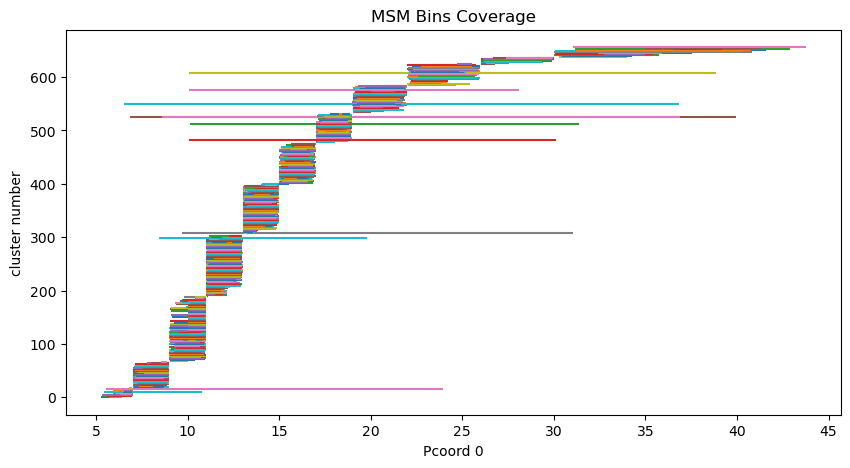

In [15]:
plot_clusters(0)

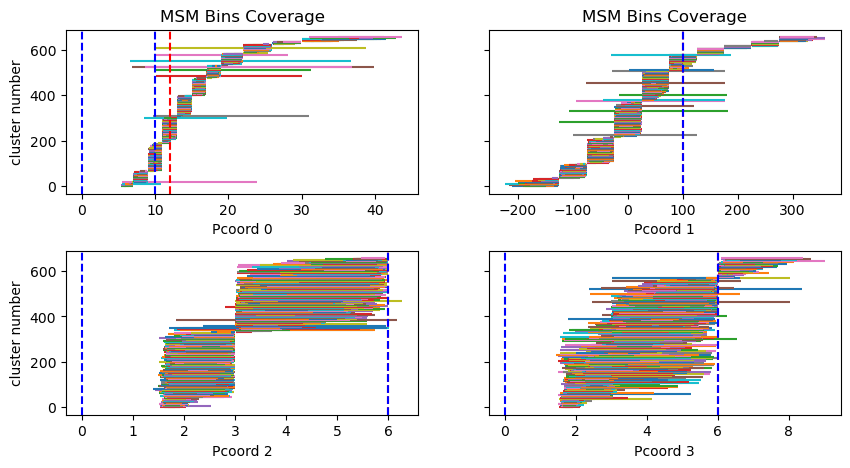

In [16]:
# making a 4 panel plot for each pcoord dim
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
for i, panel in enumerate(ax.reshape(-1)):
    plot_clusters(i, panel)
    model.draw_basis_target_boundaries(panel, i)
ax[0,1].set_ylabel("")
ax[1,1].set_ylabel("")
ax[1,0].set_title("")
ax[1,1].set_title("")
plt.subplots_adjust(hspace=0.35)

Had to adjust `_plotting.py` before `plot_flux` worked:
``` Python
322             binCenters[_model.indTargets] = _model.target_bin_centers[pcoord_to_use]
323             binCenters[_model.indBasis] = _model.basis_bin_centers[pcoord_to_use]
```

[08/31/23 11:54:33] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=174911;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=740612;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    INFO     Fluxes have not yet been generated for main_model, generating now.    ]8;id=481797;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=652531;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#311\311]8;;\

                    WARNING  Assuming fluxes should be sorted by pcoord dimension 0 -- this is     ]8;id=369406;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=132288;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#403\403]8;;\
                             currently built in to the code.                                                       

<Axes: xlabel='Pcoord 1', ylabel='Flux (weight/second)'>

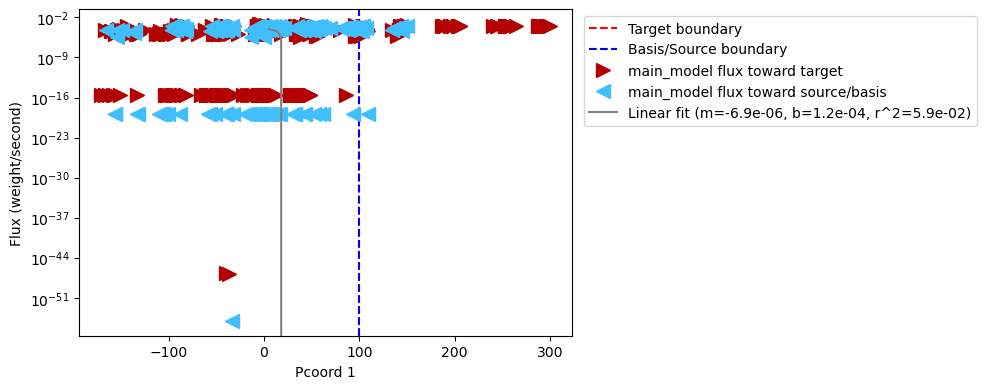

In [17]:
model.plot_flux(suppress_validation=True, pcoord_to_use=1)

[08/31/23 11:55:16] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=180436;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=794461;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    CRITICAL No cross-validation models have been generated! Do this before making ]8;id=109009;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=74821;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

                    CRITICAL No cross-validation models have been generated! Do this before making ]8;id=629963;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=665413;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

[08/31/23 11:55:17] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=590944;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=977690;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#279\279]8;;\
                             plots.                                                                                

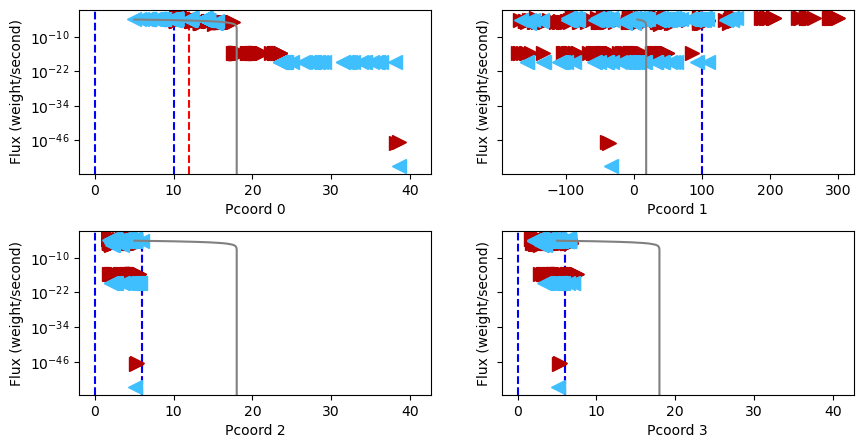

In [18]:
# making a 4 panel flux vs pcoord plot for each pcoord dim
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
for i, panel in enumerate(ax.reshape(-1)):
    model.plot_flux(suppress_validation=True, pcoord_to_use=i, ax=panel)
    
plt.subplots_adjust(hspace=0.35)

In [19]:
model.get_committor()

[08/31/23 11:55:18] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=972161;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=868125;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

  0%|          | 0/5.0 [00:00<?, ?it/s]

In [20]:
# optionally could adjust this cluster class attribute for pcoord to use (default=0)
model.pcoord_to_use = 0

[08/31/23 11:55:24] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=3482;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=547810;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

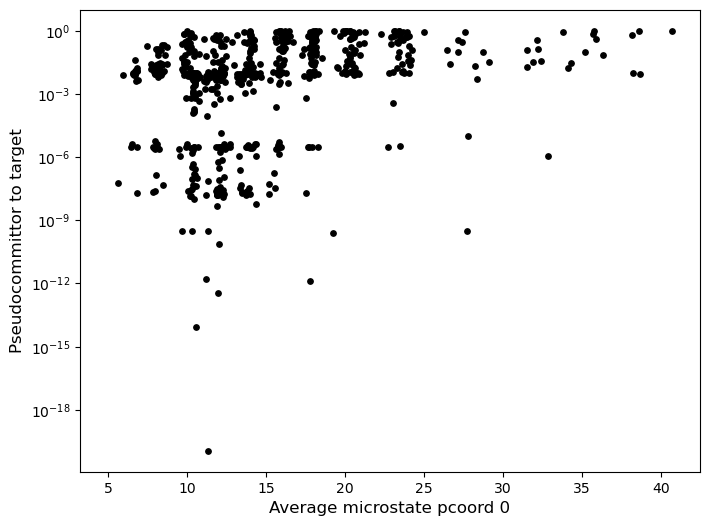

In [21]:
model.plot_committor()

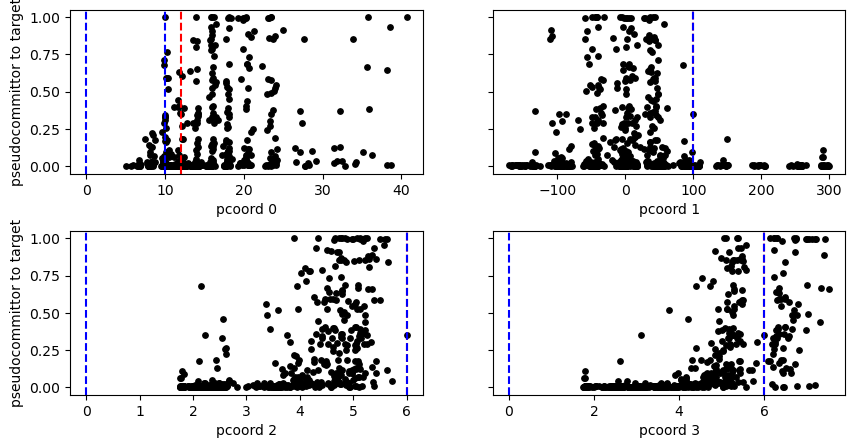

In [22]:
# making a 4 panel committor plot for each pcoord dim
fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(10,5))
for i, panel in enumerate(ax.reshape(-1)):
    panel.scatter(model.targetRMSD_centers[:,i], model.q, s=15, c='k')
    panel.set_xlabel(f"pcoord {i}")
    model.draw_basis_target_boundaries(panel, i)
ax[0,0].set_ylabel("pseudocommittor to target")
ax[1,0].set_ylabel("pseudocommittor to target")
fig.subplots_adjust(hspace=0.35)
#plt.yscale('log')

In [23]:
# first 3 center datapoints using all pcoord dims
model.targetRMSD_centers[:3,:]

array([[ 11.30687319, 259.44835772,   1.74892766,   1.74892766],
       [ 11.19381976, 289.5036602 ,   1.7476935 ,   1.75776874],
       [ 11.33909268, 299.77594573,   1.75864268,   1.76450309]])

In [24]:
# q is committor array per cluster
model.q.shape

(659,)

[08/31/23 11:55:27] CRITICAL No cross-validation models have been generated! Do this before making ]8;id=119996;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=869327;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#118\118]8;;\
                             plots.                                                                                

                    INFO     Committor-fluxes have not yet been generated for main_model,          ]8;id=151114;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py\_plotting.py]8;;\:]8;id=673015;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_plotting.py#153\153]8;;\
                             generating now.                                                                       

Obtaining pseudocommittor-fluxes:   0%|          | 0/658 [00:00<?, ?it/s]

[08/31/23 11:56:09] INFO     Note that, if steady-state weighted ensemble data is being analyzed,  ]8;id=888816;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=385018;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#642\642]8;;\
                             this is a 'pseudocommittor' and not a true committor as a result of                   
                             being constructed from a one-way ensemble.                                            

<Axes: xlabel='Pseudocommittor', ylabel='Flux (weight/second)'>

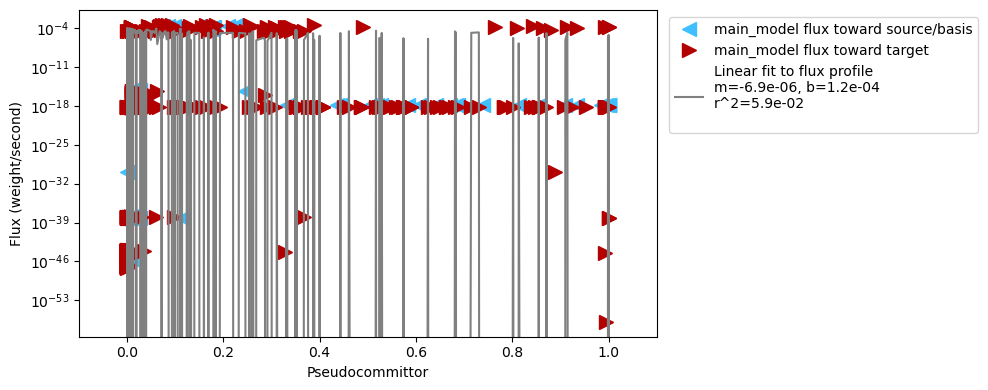

In [25]:
model.plot_flux_committor(suppress_validation=True)
#plt.gca().set_yscale('linear')
#plt.savefig('flux_pseudo_uneven_bin-restart34-t2-c18.png')

In [ ]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postvalidation.pickle', 'rb') as f:
    model = load(f)

In [26]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap_postvalidation.pickle', 'wb') as f:
    dump(model, f)

### Post-featurization Steps: Block Validation
---

In [115]:
model.do_block_validation(cross_validation_groups=2, cross_validation_blocks=8, use_ray=True)

Output()

[06/21/23 17:12:52] INFO     Beginning analysis of cross-validation group 1/2.                        ]8;id=371476;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:]8;id=663006;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py#962\962]8;;\

[06/21/23 17:19:28] INFO     Started with 7800 clusters, and removed 7372                       ]8;id=255789;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=602762;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1050\1050]8;;\

                    WARNING  All clusters were cleaned from bins {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ]8;id=26628;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=646853;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1067\1067]8;;\
                             10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,                       
                             26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,                       
                             42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,                       
                             58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,                       
                             74, 75, 76, 77, 78, 79, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92,                       
                             93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106,                        
                             107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,                      
                             120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,                      
                             133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 145, 147, 148,                      
                             149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,                      
                             163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,                      
                             176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 189,                      
                             190, 191, 193, 195, 196, 197, 199, 201, 202, 203, 205, 208, 209,                      
                             211, 213, 214, 215, 217, 218, 219, 220, 221, 223, 224, 225, 226,                      
                             227, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 241, 243,                      
                             244, 245, 247, 249, 250, 251, 253, 255, 256, 257, 259, 261, 262,                      
                             263, 265, 267, 268, 269, 271, 272, 273, 274, 275, 277, 278, 279,                      
                             280, 281, 283, 284, 285, 286, 287, 289, 290, 291, 292, 293, 295,                      
                             296, 297, 298, 299, 301, 303, 304, 305, 307, 309, 310, 311, 313,                      
                             316, 317, 319, 322, 323, 325, 328, 329, 331, 332, 333, 334, 335,                      
                             337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,                      
                             350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 361, 363, 364,                      
                             365, 367, 369, 370, 371, 373, 376, 377, 379, 382, 383, 385, 388,                      
                             389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401,                      
                             402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414,                      
                             415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 427, 429,                      
                             430, 431, 433, 436, 437, 439, 442, 443, 444, 445, 448, 449, 450,                      
                             451, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464,                      
                             465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477,                      
                             478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 489, 490, 491,                      
                             493, 496, 497, 499, 502, 503, 505, 508, 509, 510, 511, 512, 513,                      
                             514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526,             

[06/21/23 18:14:51] INFO     Note: Sorting bins, assuming that pcoord 0 is meaningful for       ]8;id=503127;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=317308;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1643\1643]8;;\
                             sorting                                                                               

                    INFO     Negative elements in pSS after normalization, attempting to correct   ]8;id=582938;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=701184;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#237\237]8;;\
                             with matrix power method.                                                             

                    INFO     Corrected to semidefinite pSS in 6 iterations                         ]8;id=310287;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=900907;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#248\248]8;;\

                    INFO                                                                           ]8;id=249250;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=358530;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#179\179]8;;\
                             Flux converged to 4.3287e-21 after 3 iterations of inverse iteration.                 

                    INFO     Beginning analysis of cross-validation group 2/2.                        ]8;id=720698;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:]8;id=791263;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py#962\962]8;;\

[06/21/23 18:22:12] INFO     Started with 7800 clusters, and removed 7218                       ]8;id=810511;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=857409;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1050\1050]8;;\

                    WARNING  All clusters were cleaned from bins {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ]8;id=848723;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=376146;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1067\1067]8;;\
                             10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,                       
                             26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,                       
                             42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,                       
                             58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,                       
                             74, 75, 76, 77, 79, 81, 82, 83, 85, 87, 88, 89, 91, 93, 94, 95,                       
                             96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,                     
                             110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,                      
                             123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,                      
                             136, 137, 139, 141, 142, 143, 145, 148, 149, 151, 153, 154, 155,                      
                             156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,                      
                             169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,                      
                             182, 183, 184, 185, 187, 188, 189, 190, 191, 193, 195, 196, 197,                      
                             199, 202, 203, 208, 209, 211, 213, 214, 215, 217, 218, 219, 220,                      
                             221, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 235, 236,                      
                             237, 238, 239, 241, 243, 244, 245, 247, 249, 250, 251, 253, 255,                      
                             256, 257, 259, 262, 263, 265, 268, 269, 271, 272, 273, 274, 275,                      
                             277, 278, 279, 280, 281, 283, 284, 285, 286, 287, 289, 290, 291,                      
                             292, 293, 295, 296, 297, 298, 299, 301, 303, 304, 305, 307, 309,                      
                             310, 311, 313, 316, 317, 319, 322, 323, 325, 328, 329, 331, 332,                      
                             333, 334, 335, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,                      
                             347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,                      
                             361, 363, 364, 365, 367, 369, 370, 371, 373, 376, 377, 379, 382,                      
                             383, 385, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,                      
                             399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,                      
                             412, 413, 414, 415, 416, 417, 418, 419, 421, 423, 424, 425, 427,                      
                             429, 430, 431, 433, 436, 437, 439, 442, 443, 444, 445, 448, 449,                      
                             450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462,                      
                             463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475,                      
                             476, 477, 478, 479, 481, 483, 484, 485, 487, 489, 490, 491, 493,                      
                             496, 497, 499, 502, 503, 505, 508, 509, 510, 511, 512, 513, 514,                      
                             515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527,                      
                             528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 541,            

[06/21/23 19:16:27] INFO     Note: Sorting bins, assuming that pcoord 0 is meaningful for       ]8;id=264574;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py\_clustering.py]8;;\:]8;id=254202;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_clustering.py#1643\1643]8;;\
                             sorting                                                                               

                    INFO     Negative elements in pSS after normalization, attempting to correct   ]8;id=50206;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=618543;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#237\237]8;;\
                             with matrix power method.                                                             

                    WARNING  Power method did NOT obtain semidefinite pSS. Some negative values    ]8;id=73271;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=584758;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#255\255]8;;\
                             remain. This is weird, and you should try to figure out why this is                   
                             happening.                                                                            

                    WARNING  Some negative  elements in pSS... Ignoring, and setting model.pSS     ]8;id=490534;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=417987;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#275\275]8;;\
                             anyways.                                                                              

[06/21/23 19:16:29] INFO                                                                           ]8;id=822804;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=694092;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#179\179]8;;\
                             Flux converged to 2.5758e-13 after 7 iterations of inverse iteration.                 

                    ERROR    Error during block validation!                                           ]8;id=150210;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:]8;id=717324;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py#995\995]8;;\

                    ERROR    Negative elements in pSS                                                 ]8;id=324309;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:]8;id=14088;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py#996\996]8;;\
                             Traceback (most recent call last):                                                    
                               File "/ihome/lchong/dty7/Apps/msm_we/msm_we/msm_we.py", line 985, in                
                             do_block_validation                                                                   
                                 _model.get_steady_state()                                                         
                               File "/ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py", line              
                             187, in get_steady_state                                                              
                                 assert (last_pSS >= 0).all(), "Negative elements in pSS"                          
                             AssertionError: Negative elements in pSS                                              

BlockValidationError: Negative elements in pSS

In [ ]:
# plot again with cross validated model
model.plot_flux_committor()

In [8]:
# For loading the clustered model data
from pickle import load
with open(f'{model_name}_400-580_4Dmap_postblockvalidation.pickle', 'rb') as f:
    model = load(f)

In [ ]:
# For saving the clustered model data
from pickle import dump
with open(f'{model_name}_400-580_4Dmap_postblockvalidation.pickle', 'wb') as f:
    dump(model, f)

#### Block validation rates

In [ ]:
for i in range(len(model.validation_models)):
    model.validation_models[i].get_steady_state_target_flux()

    print(f'Steady-state target rate is {model.validation_models[i].JtargetSS:.2e} for model {i}')

In [ ]:
list_of_rates = [model.JtargetSS, model.validation_models[0].JtargetSS, model.validation_models[1].JtargetSS]
print(np.std(list_of_rates))
print(np.average(list_of_rates))

#### Quick aside: looking at the theory and code behind $k_{AB}$ calculation

Normalizing `model.fluxMatrix` to get transition matrix, output `model.Tmatrix`.
* row-normalize the flux matrix
* set any states with 0 flux (i.e. sinks) to have 1.0
* set target bins to uniformly recycle into basis bins

In [11]:
model.get_Tmatrix()

First calculate SS probability of microbins based on SS solution of the transition matrix (`model.pSS`). 

These are calculated as the eigenvectors of the transition matrix.

In [12]:
model.get_steady_state_algebraic()

[06/15/23 12:11:28] INFO     Negative elements in pSS after normalization, attempting to correct   ]8;id=623078;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=966892;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#237\237]8;;\
                             with matrix power method.                                                             

                    INFO     Corrected to semidefinite pSS in 176 iterations                       ]8;id=395661;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py\_analysis.py]8;;\:]8;id=933098;file:///ihome/lchong/dty7/Apps/msm_we/msm_we/_hamsm/_analysis.py#248\248]8;;\

Calculate sum of target state ss flux ($k_{AB}$) via https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8045600/#FD3 equation 3:

$k_{AB} = Flux(A \rightarrow B;SS) = \sum_{i\notin B, j\in B} p_{i}^{\alpha}T_{ij}^{\alpha}$ (haMSM)

Here, $p^{\alpha}$ is given by `model.pSS` and $T^{\alpha}$ is given by `model.Tmatrix`.

Running `model.get_steady_state_target_flux()` calculates $k_{AB}$, output `model.JtargetSS`.

In [13]:
model.get_steady_state_target_flux()

In [14]:
model.JtargetSS

1.9954185219363416e-21

### Getting model outputs
---

Block validation output

In [ ]:
import weight_loop
for idx, v_model in enumerate(model.validation_models):
    if idx == 0:
        continue
    weight_loop.create_reweighted_h5_global(v_model,new_name=f'west_{idx}.h5')

Use haMSM weights to create new west.h5 file, use this updated west.h5 file for running subsequent WE simulations.

In [ ]:
import weight_loop

weight_loop.create_reweighted_h5_global(model, west_name='west_nocoords.h5', copy=True, 
                                        struct_filetype='ncrst', new_name=f'west_reweight.h5', 
                                        gen_sstates=True, pdb_out=False, link_out=True, 
                                        link_path="/ocean/projects/mcb180038p/jml230/bdpa_wsh2029_p3_r3",)

Extract transition state (pseudo-committor of a certain range)